In [85]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib import pyplot as plt

In [ ]:
df_train.describe()

In [38]:
df_train = pd.read_csv("df_train.csv").dropna()
df_test = pd.read_csv("df_test.csv").dropna()

In [39]:
# Use one-hot encoding for categorical variable
X_train_raw = df_train.drop(columns = ['crime','police_district'])
X_test_raw = df_test.drop(columns = ['crime','police_district'])
X_train_dummy = pd.get_dummies(X_train_raw, 
                               columns = ['incident_day_of_week','incident_hour','zipcode'], 
                               drop_first = True)
X_test_dummy = pd.get_dummies(X_test_raw, 
                               columns = ['incident_day_of_week','incident_hour','zipcode'], 
                               drop_first = True)

In [40]:
# Standardize the numerical columns.
def standardize(df, cols, df_train):
    scalar = StandardScaler().fit(df_train[cols])
    result = df.copy()
    transformed_cols = scalar.transform(result[cols])
    result = result.drop(cols, 1)
    for i in range(len(cols)): 
        col = cols[i]
        result[col] = transformed_cols[:, i]
    return result
cols = ['population','population_density','housing_units',
        'occupied_housing_units','median_home_value','median_household_income']
X_train_clean = standardize(X_train_dummy,cols,X_train_dummy)
X_test_clean = standardize(X_test_dummy,cols,X_test_dummy)
X_train_clean.describe()

,incident_day_of_week_Monday,incident_day_of_week_Saturday,incident_day_of_week_Sunday,incident_day_of_week_Thursday,incident_day_of_week_Tuesday,incident_day_of_week_Wednesday,incident_hour_1,incident_hour_2,incident_hour_3,incident_hour_4,...,zipcode_94131.0,zipcode_94132.0,zipcode_94134.0,zipcode_94158.0,population,population_density,housing_units,occupied_housing_units,median_home_value,median_household_income
count,9874.000000,9874.000000,9874.000000,9874.000000,9874.000000,9874.000000,9874.000000,9874.000000,9874.000000,9874.000000,...,9874.000000,9874.000000,9874.000000,9874.000000,9.874000e+03,9.874000e+03,9.874000e+03,9.874000e+03,9.874000e+03,9.874000e+03
mean,0.143711,0.142192,0.138141,0.142293,0.143204,0.144318,0.035548,0.035143,0.033421,0.033016,...,0.046790,0.021065,0.038687,0.061981,1.539740e-16,-1.772039e-17,5.415064e-17,1.637112e-17,6.906568e-17,2.735136e-16
std,0.350814,0.349264,0.345065,0.349368,0.350299,0.351430,0.185169,0.184150,0.179743,0.178687,...,0.211198,0.143610,0.192859,0.241133,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.603278e+00,-1.353998e+00,-1.720937e+00,-1.721972e+00,-1.956870e+00,-1.650100e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-4.823698e-01,-7.768312e-01,-5.559845e-01,-5.702752e-01,-9.358253e-01,-8.387819e-01
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-8.267377e-02,-2.434731e-01,-6.630343e-02,-8.355931e-02,-2.751042e-02,1.823780e-01
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.928301e-01,4.736721e-01,3.944806e-01,4.254396e-01,9.008884e-01,5.754958e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,2.300825e+00,2.078022e+00,2.402375e+00,2.290800e+00,1.474261e+00,2.724020e+00


In [41]:
X_test_clean.describe()

,incident_day_of_week_Monday,incident_day_of_week_Saturday,incident_day_of_week_Sunday,incident_day_of_week_Thursday,incident_day_of_week_Tuesday,incident_day_of_week_Wednesday,incident_hour_1,incident_hour_2,incident_hour_3,incident_hour_4,...,zipcode_94131.0,zipcode_94132.0,zipcode_94134.0,zipcode_94158.0,population,population_density,housing_units,occupied_housing_units,median_home_value,median_household_income
count,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.00000,9854.000000,...,9854.000000,9854.000000,9854.000000,9854.000000,9.854000e+03,9.854000e+03,9.854000e+03,9.854000e+03,9.854000e+03,9.854000e+03
mean,0.142785,0.140857,0.140045,0.142683,0.143597,0.142277,0.036939,0.035214,0.03491,0.032474,...,0.050233,0.020093,0.038259,0.061701,6.338659e-17,-3.449646e-16,-8.477083e-17,-1.151009e-16,3.486544e-16,1.392567e-17
std,0.349871,0.347891,0.347051,0.349767,0.350698,0.349352,0.188622,0.184330,0.18356,0.177265,...,0.218437,0.140327,0.191830,0.240624,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.622604e+00,-1.360095e+00,-1.738735e+00,-1.740357e+00,-1.963390e+00,-1.655836e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-4.899561e-01,-7.814343e-01,-5.678083e-01,-5.822956e-01,-9.378821e-01,-8.431413e-01
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-8.607375e-02,-2.466956e-01,-7.561599e-02,-9.288996e-02,-2.559656e-02,1.797514e-01
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.944105e-01,4.723062e-01,3.875311e-01,4.189219e-01,9.068608e-01,5.735362e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,1.000000,1.000000,1.000000,2.322390e+00,2.080809e+00,2.405722e+00,2.294591e+00,1.482739e+00,2.725706e+00


In [42]:
# Get y_train and y_test
y_train = df_train.crime
y_test = df_test.crime

## Linear Regression

In [51]:
OS =LinearRegression()
OS.fit(X_train_clean,y_train)
OS.score(X_test_clean,y_test)

-6.40705667686908e+18

In [62]:
# Check colinearity
X_numerical = X_train_clean[cols]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_numerical.values, i) for i in range(X_numerical.shape[1])]
vif["features"] = X_numerical.columns
vif.round(1)

,VIF Factor,features
0,21.5,population
1,2.8,population_density
2,1879.9,housing_units
3,2159.5,occupied_housing_units
4,2.0,median_home_value
5,1.7,median_household_income


In [73]:
# Dropout columns with huge VIF Factor
X_train_final = X_train_clean.drop(columns=['population','housing_units','occupied_housing_units','population_density','median_home_value','median_household_income'])
X_test_final = X_test_clean.drop(columns=['population','housing_units','occupied_housing_units','population_density','median_home_value','median_household_income'])

In [88]:
OS =LinearRegression()
OS.fit(X_train_clean,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [89]:
y_pred = OS.predict(X_test_clean)

Text(0, 0.5, 'Number of Crime')

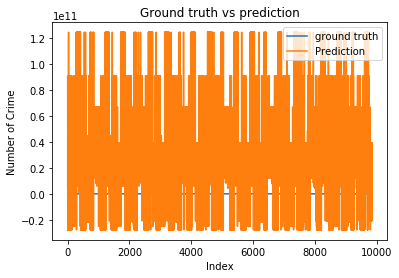

In [91]:
plt.plot(np.arange(len(y_test)),y_test,label = "ground truth")
plt.plot(np.arange(len(y_test)),y_pred,label = "Prediction")
plt.legend()
plt.title("Ground truth vs prediction")
plt.xlabel("Index")
plt.ylabel("Number of Crime")